# ∆QT Database

Sample notebook for querying ∆QT Database (web app at http://www.deltaqt.org)

Can also incorporate Twosides for gathering additional evidence for drug-side effect relationships 

**Input:**  [Drug(s) to evaluate from list of drugs in database](#input)

**Step 1:** [Define function for extracting ∆QTs from API](#step1)

**Step 2:** [API call to obtain ∆QTs for each individual drug and combination](#step2)

**Step 3:** [Bin ∆QTs for visualizing in histogram](#step3)

**Step 4:** [Visualize ∆QTs](#step4)


In [1]:
%matplotlib inline

In [3]:
from urllib2 import Request, urlopen, URLError
import json

import numpy as np
# from scipy.interpolate import interp1d
from collections import defaultdict

import matplotlib.pyplot as plt
#import seaborn as sns

### Demo

<a id='input'></a>
**Input:** Drug(s) to evaluate from list of drugs in database

In [4]:
# Obtain list of possible drugs
concept2name = dict()
name2concept = dict()

request = Request('http://deltaqt.org/index/js/drugs-brandnames-v4.js')
response = urlopen(request).read()

for line in response.split('\n'):
    if line.startswith('//') == False and line.startswith('var') == False and line not in ['','];']:
        if line.split("'")[1].startswith('('):
            continue
        concept_id = int(line.split("'")[1])
        drugname = line.split("'")[-2].split('(')[0].strip()
        print concept_id, drugname
        concept2name[concept_id] = drugname
        name2concept[drugname] = concept_id

print '\n',len(concept2name), "drugs found"

1309944 Amiodarone
1314002 Atenolol
1346823 Carvedilol
1326303 Digoxin
989878 Lidocaine
1307046 Metoprolol
1353766 Propranolol
1713332 Amoxicillin
1717327 Ampicillin
1734104 Azithromycin
1715117 Aztreonam
915175 Bacitracin
1771162 Cefazolin
1774470 Cefotaxime
1775741 Cefoxitin
1777806 Ceftriaxone
1778162 Cefuroxime
1786621 Cephalexin
1797513 Ciprofloxacin
1759842 Clavulanate
997881 Clindamycin
1738521 Doxycycline
1746940 Erythromycin
919345 Gentamicin sulfate
1742253 Levofloxacin
1736887 Linezolid
1709170 Meropenem
1707164 Metronidazole
951511 Mupirocin
920293 Nitrofurantoin
1724703 Oxacillin
1728416 Penicillin G
1746114 Piperacillin
948582 Polymyxin B
1836241 Sulbactam
1836430 Sulfamethoxazole
1741122 Tazobactam
902722 Tobramycin
1705674 Trimethoprim
1707687 Vancomycin
1000632 Clotrimazole
1754994 Fluconazole
907879 Miconazole
922570 Nystatin
941472 Terconazole
904453 Esomeprazole
929887 Lansoprazole
923645 Omeprazole
948078 Pantoprazole
750982 Bupropion
797617 Citalopram
715939 Escit

In [5]:
# Test for amiodarone alone
print name2concept['Amiodarone']
drugs = [1309944]
drugs_api_str = ",".join([str(d) for d in drugs])
drugs_api_str

1309944


'1309944'

In [6]:
# Test for ceftriaxone and lansoprazole
print name2concept['Ceftriaxone'], name2concept['Lansoprazole']
drugs = [1777806, 929887]
drugs_api_str = ",".join([str(d) for d in drugs])
drugs_api_str

1777806 929887


'1777806,929887'

<a id='step1'></a>
**Step 1:** Define function for extracting ∆QTs from API

In [7]:
def pull_deltas(drugs_api_str, cached=False):
    if ',' in drugs_api_str:
        cached = True
    
    delta_qts = []
    cached_qts = []
    request = Request('http://deltaqt.org/api/v1/query?drugs=%s' %drugs_api_str)
    
    try:
        response = urlopen(request).read()
        decoded = json.loads(response)
        #print len(decoded)

        for p in decoded['delta_qts']:
            delta_qts.append( p['delta'] )
            
        if cached == True:
            for p in decoded['cache_'+drugs_api_str.split(',')[1]]:
                cached_qts.append( p['delta'] )
            
    except URLError, e:
        print '%s not found in database' %drugs_api_str, e
    
    if cached == True:
        return delta_qts, cached_qts
    else:
        return delta_qts

<a id='step2'></a>
**Step 2:** API call to obtain ∆QTs for each individual drug and combination

In [8]:
print drugs
drugs_api_str = ",".join([str(d) for d in drugs])

delta_qts = []
individ_drug_qts = defaultdict(list)

if len(drugs) == 1:
    delta_qts = pull_deltas(drugs_api_str)
elif len(drugs) > 1:
    # API returns deltas for patients taking all N drugs, and for the Nth drug alone
    # Need to run API for 1 – (N-1)th drugs
    for d in drugs[0:-1]:
        individ_drug_qts[d] = pull_deltas(str(d))
    
    delta_qts, individ_drug_qts[drugs[-1]] = pull_deltas(drugs_api_str)

[1777806, 929887]


<a id='step3'></a>
**Step 3:** Bin ∆QTs for visualizing in histogram

In [9]:
thresholds = [-110, -100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

bins = dict()

delta_qts_arr = np.array(delta_qts)
weights = np.ones_like(delta_qts_arr)/float(len(delta_qts_arr))*100.0
hist, bin_edges = np.histogram(delta_qts_arr, weights=weights, bins=thresholds)
bins['all'] = hist

if len(drugs) > 1:
    for d in individ_drug_qts:
        individ_drug_qts_arr = np.array(individ_drug_qts[d])
        weights = np.ones_like(individ_drug_qts_arr)/float(len(individ_drug_qts_arr))*100.0
        hist, bin_edges = np.histogram(individ_drug_qts_arr, weights=weights, bins=thresholds)
        bins[d] = hist
print len(bins), "bins"

3 bins


<a id='step4'></a>
**Step 4:** Visualize ∆QTs

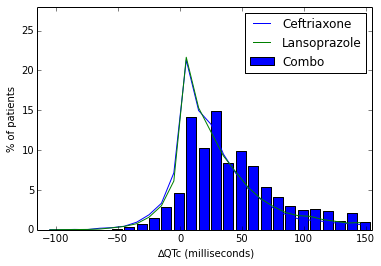

In [10]:
xpos = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
if len(drugs) == 1:
    plt.bar(xpos, bins['all'], width=8, label=concept2name[drugs[0]])

elif len(drugs) > 1:
    plt.bar(xpos, bins['all'], width=8, label='Combo')
    for d in drugs:
        plt.plot(xpos, bins[d], label=concept2name[d])

plt.xlim(-115,155)
plt.ylim(0,28)
plt.xlabel(u'∆QTc (milliseconds)')
plt.ylabel('% of patients')
plt.legend()

---

## Background

### Current Status

- Accesses CHEBI data via the BioLink API
- Accesses GINAS data via their API
- Trying to *join* information about 'acetylsalicylic acid' from both data sources, as a toy problem to get started.
- We're going to look up 'acetylsalicylic acid' rather than 'aspirin', because it is a common term in all of the sources right now and I'm not sure that the Monarch BioLink API I'm using has the term 'aspirin' yet.


### Next Steps

- Explore [Pharos](https://pharos.nih.gov/idg/index) API and data sources
- Use [mybinder](http://mybinder.org) badge (or a similar hosted Jupyter mechanism) to simplify invocation and editing from GitHub
- Try to extract Drug-to-conditions and Condition-to-Drugs relations from sources. Use competency questions to guide this integration.
- Consider WikiData as a source
- Accommodate anticipated BROAD probability models, possibly by developing a mock API.


---

## Data Sources

### CHEBI Data

Monarch ingests [Chemical Entities of Biological Interest (ChEBI)](https://www.ebi.ac.uk/chebi/) data and makes it available via SciGraph, the Monarch API, and the new BioLink API.

For reference, here is the link to CHEBI's entry for 'acetylsalicylic acid' (aka 'Aspirin'):

[CHEBI:15365 acetylsalicylic acid](https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:15365)


### BioLink substance data from CHEBI via Monarch

Monarch has ingested CHEBI data, and we have a `/biolink/substance/{id}/participant_in/` endpoint that seems to return some data:

https://api.monarchinitiative.org/api/bioentity/substance/CHEBI:40036/participant_in/

However, the basic `/biolink/substance/{id}` endpoint returns no useful data, so we'll have to use the above link until BioLink has a fleshed out `/substance` endpoint.



### ginas API Substance data from ginas

The [Global Ingredient Archival System (ginas)](https://tripod.nih.gov/ginas/#/) provides a common identifier for all of the substances used in medicinal products, utilizing a consistent definition of substances globally, including active substances under clinical investigation. More info at [NCATS ginas](https://ncats.nih.gov/expertise/preclinical/ginas).

#### Examples

- [ginas Aspirin](https://tripod.nih.gov/ginas/app/api/v1/substances/search?q=root_names_name:"^ASPIRIN$")

- [ginas acetylsalicylic acid](https://tripod.nih.gov/ginas/app/api/v1/substances/search?q=root_names_name:"^acetylsalicylic acid$")



